# Deep source 9

This notebook explains that how you can runn deepsource9 to train a CNN on images.

In [2]:
import sys
import glob
import numpy as np
import deepsource9 as ds9

import matplotlib.pylab as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

It second notebook, we explained that how you can define a data provider for CNN feeding.

number of files:  6 , number of channels:  1


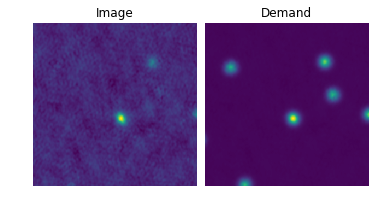

In [3]:
rb = 0
restore=0
patch_size = 400

def kernel1(cat):
    return ds9.horn_kernel(cat,radius=10,step_height=2)
def kernel2(cat):
    return ds9.gaussian_kernel(cat,sigma=7)

images_path=['../data/image'+str(i+1)+'.fits' for i in range(6)]
models_path=['../data/image'+str(i+1)+'.txt' for i in range(6)]
ppdp = ds9.GeneralDataProvider(images_path=images_path,models_path=models_path,margin=0,
                                     nx=300, ny=300,kernels=[kernel1,kernel2], b_n=0.1, alpha=0.3)

x,y = ppdp(1)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(6,3)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(x[0,:,:,0])
ax.set_title('Image')
plt.axis('off')

ax = plt.subplot(gs[0, 1])
ax.imshow(y[0,:,:,0])
ax.set_title('Demand')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

Then you can use "ppdp" to feed convolutional neural network (CNN). CNN will be trained to transform an image to corresponding demand. "ConvolutionalLayers" class provides a CNN for this purpose. You can easily specify any desired architecture and train/save/restore it. In bellow example there is an architecture defined in file "arch.py" placed in current directory. You can train you CNN using train method:

In [ ]:
rb = 0
restore=0
patch_size = 300

cnn = ds9.ConvolutionalLayers(nl=patch_size,learning_rate = 0.001,n_channel=1,
                              restore=1,model_add='./cmodel',arch_file_name='arch')

cnn.train(ppdp,training_epochs=100,n_s=1, dropout=0.2,verbose=5)

If you want to restore your trained model to use or tue up, you can set the "restore" argument to 1. Then "conv" methos can transform any image to demand:

In [ ]:
x,y = ppdp(1)
xf = cnn.conv(x)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(7.5,3.5)) 

ax = plt.subplot(gs[0, 0])
plt.axis('off')
ax.set_title('Data')
ax.imshow(x[0,10:-10,10:-10,0])

ax = plt.subplot(gs[0, 1])
plt.axis('off')
ax.set_title('CNN-output')
ax.imshow(xf[10:-10,10:-10])

ax = plt.subplot(gs[0, 2])
plt.axis('off')
ax.set_title('Demand')
ax.imshow(y[0,10:-10,10:-10,0])

plt.subplots_adjust(wspace=0.05,bottom=0.0, top=0.92, left=0.02, right=0.98)

Now let's transform a whole image and extract point sources from demand map. Since operating on a large image may consume big amount of memory, there is a method to do this job by tiling. 

In [ ]:
image_file = '../data/image7.fits'
model_file = '../data/image7.txt'

catalog = ds9.ps_extract(image_file,model_file,cnn,ds9.fetch_data,loc_det='mean',
                        ignore_border=0,jump_lim=3,area_lim=10,lw=300,pad=10)

In [ ]:
ds9.visualize_cross_match(image_file,model_file,catalog)